# Improving Image Resolution with Autoencoders

![IMAGE](https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/ezgif-3-0c564ff8a43d.gif)

#### Autoencoders can be used for increasing Image Resolution and this has proved to be effective when we want extract information from the feeds of Surveillance Cameras and autoencoders can also be used for Noise Reduction and they can serve as part of various IIoT Applications.

## Downloading the Dataset

#### Data has been taken from the [Imagenet dataset](http://image-net.org/download).

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/data.zip"
!unzip -o data.zip 
!rm data.zip

## Building the Autoencoder

In [3]:
# Importing necessary Libraries
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Building the encoder
input_img = Input(shape=(256, 256, 3))
l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)

In [4]:
# Building the Decoder

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

decoded = Conv2D(3, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder = Model(input_img, decoded)

In [5]:
autoencoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## Defining the Callbacks and Compiling the Model

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
checkpointer = ModelCheckpoint(filepath = "model1.h5", verbose = 2, save_best_only = True)

## Reading the images from Directory and Creating the Dataset and Defining Training Routine

In [14]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np

def train_batches(just_load_dataset=False):
    # Number of images to have at the same time in a batch
    batches = 256 
    
    # Number if images in the current batch (grows over time and then resets for each batch)
    batch = 0 
    
    # For printing purpose
    batch_nb = 0
    
    max_batches = -1
    
    # Number of epochs
    ep = 4 

    images = []
    x_train_high = []
    x_train_low = []
    
    x_train_high2 = [] # Resulting high res dataset
    x_train_low2 = [] # Resulting low res dataset
    
    for root, dirnames, filenames in os.walk("data"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                    
                    # Resize the image so that every image is the same size
                    image_resized = resize(image, (256, 256)) 
                    x_train_high.append(image_resized) # Add this image to the high res dataset
                    x_train_low.append(rescale(rescale(image_resized, 0.5, multichannel=True), 2.0, multichannel=True)) # Creating the blurred images
                    batch += 1
                    if batch == batches:
                        
                        x_train_high2 = np.array(x_train_high)
                        x_train_low2 = np.array(x_train_low)
                        
                        if just_load_dataset:
                            return x_train_high2, x_train_low2
                        
                        batch_nb += 1
                        print('Training batch', batch_nb)

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15,
                            callbacks = [checkpointer] )
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

## Training the model

In [15]:
x_train_n, x_train_down = train_batches(just_load_dataset=False)

Training batch 1
Epoch 1/4
22/22 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00001: val_loss improved from inf to 0.00137, saving model to model1.h5
22/22 [==============================] - 18s 821ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 2/4
22/22 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00002: val_loss improved from 0.00137 to 0.00137, saving model to model1.h5
22/22 [==============================] - 18s 804ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/4
22/22 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00003: val_loss improved from 0.00137 to 0.00137, saving model to model1.h5
22/22 [==============================] - 18s 803ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/4
22/22 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00004: val_loss improved from 0.00137 to 0.00137, saving model to model1.h5
22/22 [==============================] - 18s 801ms/step - loss: 0.0015 - val_loss: 0.0014
Tra

### Loading The saved Model

In [1]:
import tensorflow as tf
new_model1 = tf.keras.models.load_model('model1.h5')

new_model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## Visualizing the results

In [25]:
# We clip the output so that it doesn't produce weird colors
sr1 = np.clip(new_model.predict(x_train_down), 0.0, 1.0)
image_index = 210

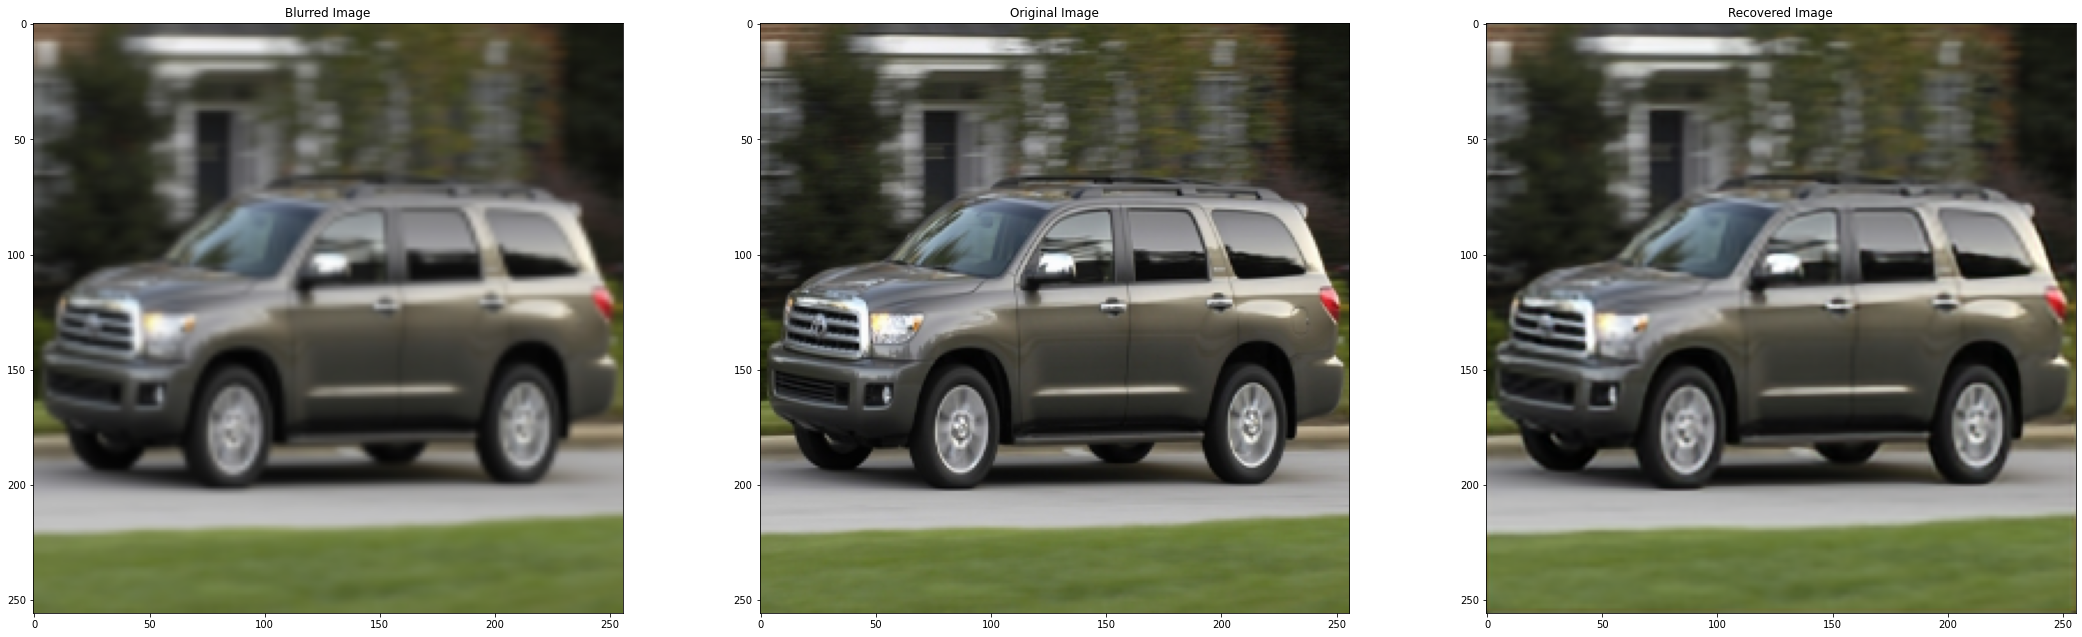

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.title("Blurred Image")
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.title("Original Image")
plt.imshow(x_train_n[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.title("Recovered Image")
plt.imshow(sr1[image_index])
plt.show()

## Cimpiling the Model using DeepCC

In [2]:
!deepCC model1.h5

reading [keras model] from 'model1.h5'
Saved 'model1.onnx'
reading onnx model from file  model1.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): graph-node conv2d's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_3's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_4's attribute auto_pad has no meaningful data.
WARN (ONNX): scales is not a valid graph-node attribute.
             operator Upsample will be added without this attribute.
WARN (ONNX): graph-node conv2d_5's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_6's attribute auto_pad has no meaningful data.
WARN (ONNX): scales is not a valid graph-node attribute.
             operator Upsample will be added without this attribute.
WARN (ONNX): graph-node conv2d_7's attribute auto_pad has 